In [1]:
import pandas as pd
import numpy as np
from torchvision import transforms
from textDataset import *

from models import BoWClassifier, Tfid

import torch
import torch.nn as nn
import torch.optim as optim

from trainner import TrainnerNLP

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE


%matplotlib inline  

In [2]:
path2data = '../data/assigment/'

text = {
        'train': TextDataset(path2data + 'train/', is_train = True),
}    

In [3]:
text['train'].process_data(col = 'headline_text', remove_stopw = True, remove_tags=True)

In [4]:
sentences = { 'train': text['train'].data['headline_text_data'].values,
}

In [5]:
# train model
model = Word2Vec(sentences['train'], min_count=100)

## Words visualization using PCA

/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


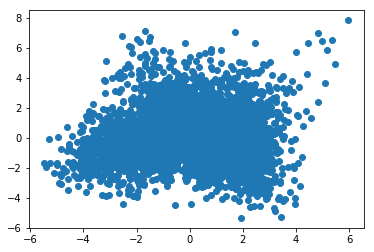

In [6]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.scatter(result[:, 0], result[:, 1])
plt.show()

## Words visualization using t-SNE

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot(model)

/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
